Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (to be dropped):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []

Dataset shape after dropping rows with missing dates: (1005167, 5)
Remaining missing values:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64

Removing outliers...
Outliers saved to 'removed_outliers.csv'.
Outliers removed. Dat

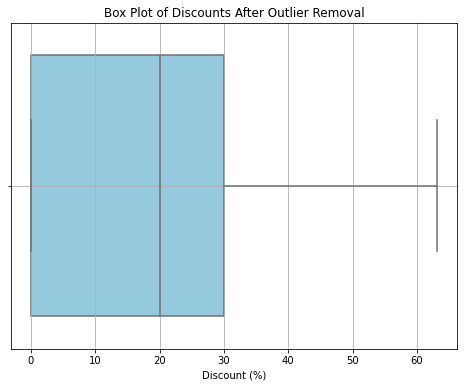

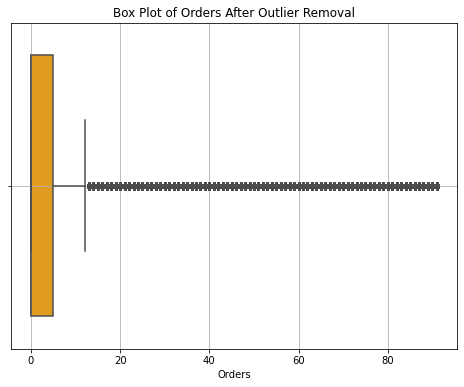

Insight: After removing extreme values, the distribution of 'discount' and 'orders' is more representative of the majority of the data.
Filtered dataset to top 10 departments by orders. Shape: (975378, 5)
Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (to be dropped):")
print(missing_date_rows)

# Drop rows with missing `date_of_order`
data_cleaned.dropna(subset=['date_of_order'], inplace=True)
print(f"\nDataset shape after dropping rows with missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
data_cleaned['department_desc'].fillna('Unknown', inplace=True)  # Replace missing department descriptions
data_cleaned['discount'].fillna(data_cleaned['discount'].median(), inplace=True)  # Fill missing `discount` with median
data_cleaned['orders'].fillna(data_cleaned['orders'].median(), inplace=True)  # Fill missing `orders` with median
print(f"Remaining missing values:\n{data_cleaned.isnull().sum()}")

# 4. Custom Outlier Removal using Percentiles
def remove_outliers_custom(df, column, lower_percentile, upper_percentile):

    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return filtered_df, outliers_df

print("\nRemoving outliers...")
original_shape = data_cleaned.shape
data_cleaned, discount_outliers = remove_outliers_custom(data_cleaned, 'discount', lower_percentile=1, upper_percentile=99)
data_cleaned, order_outliers = remove_outliers_custom(data_cleaned, 'orders', lower_percentile=1, upper_percentile=99)

# Combine all outliers
all_outliers = pd.concat([discount_outliers, order_outliers]).drop_duplicates()
all_outliers.to_csv('removed_outliers.csv', index=False)
print(f"Outliers saved to 'removed_outliers.csv'.")
print(f"Outliers removed. Dataset shape before: {original_shape}, after: {data_cleaned.shape}")

# Box Plots after Outlier Removal
# Box plot for discounts after outlier removal
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['discount'], color='skyblue')
plt.title('Box Plot of Discounts After Outlier Removal')
plt.xlabel('Discount (%)')
plt.grid(True)
plt.show()

# Box plot for orders after outlier removal
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned['orders'], color='orange')
plt.title('Box Plot of Orders After Outlier Removal')
plt.xlabel('Orders')
plt.grid(True)
plt.show()

print("Insight: After removing extreme values, the distribution of 'discount' and 'orders' is more representative of the majority of the data.")

# 6. Filter relevant departments
top_departments = data_cleaned.groupby('department_desc')['orders'].sum().nlargest(10).index
data_cleaned = data_cleaned[data_cleaned['department_desc'].isin(top_departments)]
print(f"Filtered dataset to top 10 departments by orders. Shape: {data_cleaned.shape}")

# 7. Save the cleaned and preprocessed data
data_cleaned.to_csv('cleaned_orders_discount_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_orders_discount_data.csv'.")



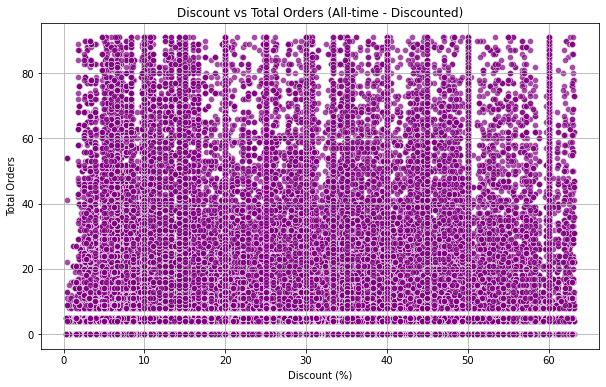

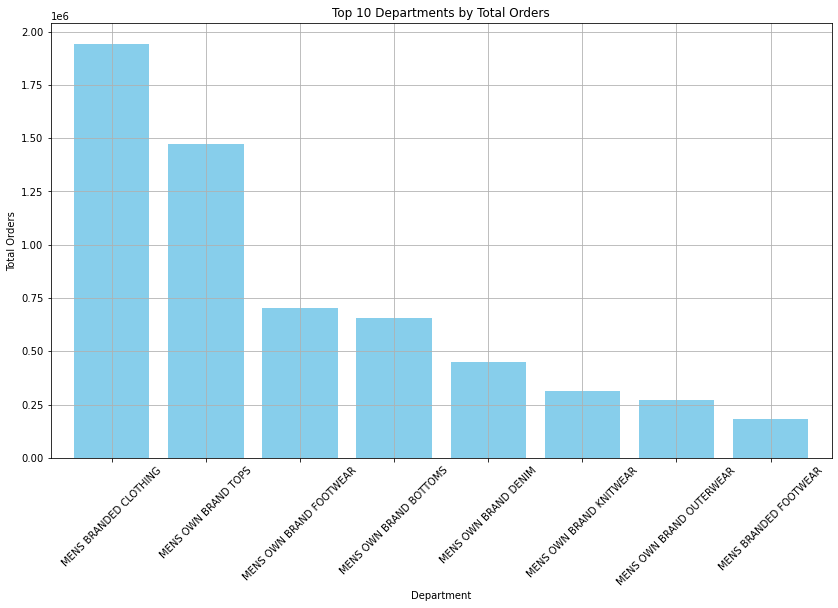

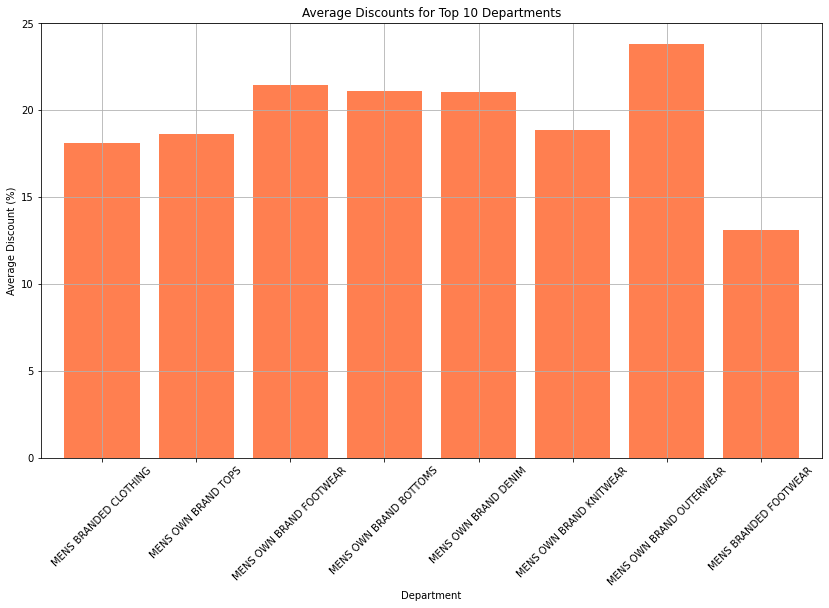

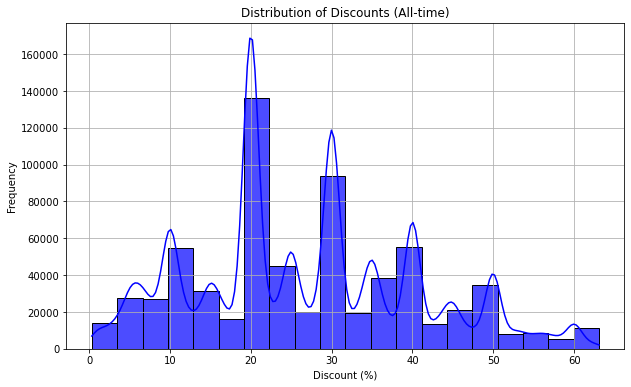

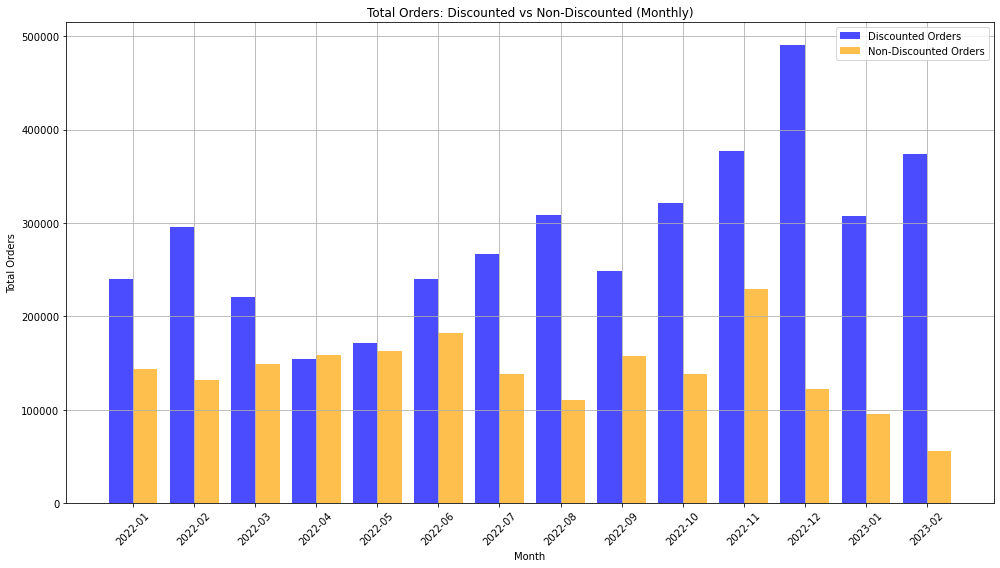

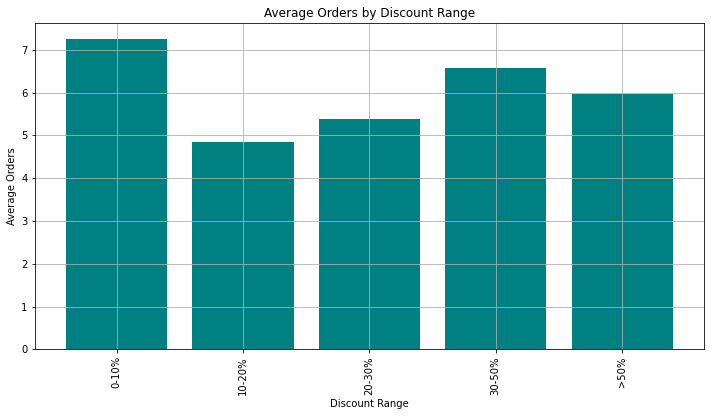

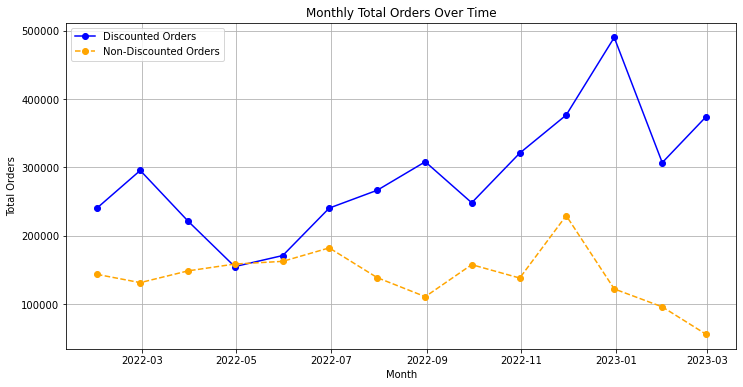

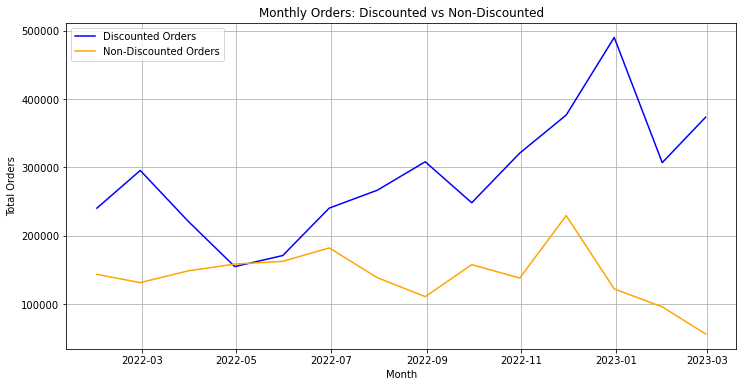

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
file_path = 'cleaned_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate discount segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Replace NaN with 0 to handle months without any orders for a specific category
monthly_data.fillna(0, inplace=True)

# Add discount range for analysis (for discounted data only)
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
if 'discount_discounted' in monthly_data.columns:
    monthly_data['discount_range'] = pd.cut(monthly_data['discount_discounted'], bins=bins, labels=labels)

### 1. Discount vs Orders Scatter Plot (All-time Aggregation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discounted_data, alpha=0.7, color="purple")
plt.title('Discount vs Total Orders (All-time - Discounted)')
plt.xlabel('Discount (%)')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

### 2. Top Departments by Total Orders
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

plt.figure(figsize=(14, 8))  # Wider chart
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue', width=0.8)
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Average Discounts for Top 10 Departments
plt.figure(figsize=(14, 8))  # Wider chart
dept_aggregated['discount'].head(10).plot(kind='bar', color='coral', width=0.8)
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 4. Distribution of Discounts
plt.figure(figsize=(10, 6))
sns.histplot(discounted_data['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts (All-time)')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 5. Discounted vs Non-Discounted Sales (Monthly)
# Adjust x-axis positions to prevent overlap
x_positions = np.arange(len(monthly_data['date_of_order']))

plt.figure(figsize=(14, 8))  # Wider chart for better readability
plt.bar(
    x_positions - 0.2,  # Offset for Discounted Orders
    monthly_data['orders_discounted'],
    width=0.4,
    label='Discounted Orders',
    color='blue',
    alpha=0.7
)
plt.bar(
    x_positions + 0.2,  # Offset for Non-Discounted Orders
    monthly_data['orders_non_discounted'],
    width=0.4,
    label='Non-Discounted Orders',
    color='orange',
    alpha=0.7
)

# Set x-axis labels
plt.xticks(x_positions, monthly_data['date_of_order'].dt.strftime('%Y-%m'), rotation=45)
plt.title('Total Orders: Discounted vs Non-Discounted (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label overlap
plt.show()

### 6. Average Orders by Discount Range
avg_orders_by_discount = discounted_data.groupby(pd.cut(discounted_data['discount'], bins=bins, labels=labels))['orders'].mean()

plt.figure(figsize=(12, 6))
avg_orders_by_discount.plot(kind='bar', color='teal', width=0.8)
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

### 7. Monthly Total Orders Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date_of_order'], monthly_data['orders_discounted'], marker='o', color='blue', label='Discounted Orders')
plt.plot(monthly_data['date_of_order'], monthly_data['orders_non_discounted'], marker='o', linestyle='--', color='orange', label='Non-Discounted Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

### 8. Monthly Orders: Discounted vs Non-Discounted
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_of_order', y='orders_discounted', data=monthly_data, label='Discounted Orders', color='blue')
sns.lineplot(x='date_of_order', y='orders_non_discounted', data=monthly_data, label='Non-Discounted Orders', color='orange')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()



Discounted Monthly Aggregation:
  date_of_order  orders   discount
0    2022-01-31  240409  25.488877
1    2022-02-28  295644  25.979146
2    2022-03-31  221103  26.231815
3    2022-04-30  154862  28.056034
4    2022-05-31  171060  26.709632

Non-Discounted Monthly Aggregation:
  date_of_order  orders
0    2022-01-31  143535
1    2022-02-28  131390
2    2022-03-31  148674
3    2022-04-30  158577
4    2022-05-31  162558

Merged Monthly Data (after NaN removal):
  date_of_order  orders_discounted   discount  orders_non_discounted
0    2022-01-31             240409  25.488877                 143535
1    2022-02-28             295644  25.979146                 131390
2    2022-03-31             221103  26.231815                 148674
3    2022-04-30             154862  28.056034                 158577
4    2022-05-31             171060  26.709632                 162558
Pearson Correlation (Discounted Orders): -0.180
Spearman Correlation (Discounted Orders): -0.068

Average Price Elasticit

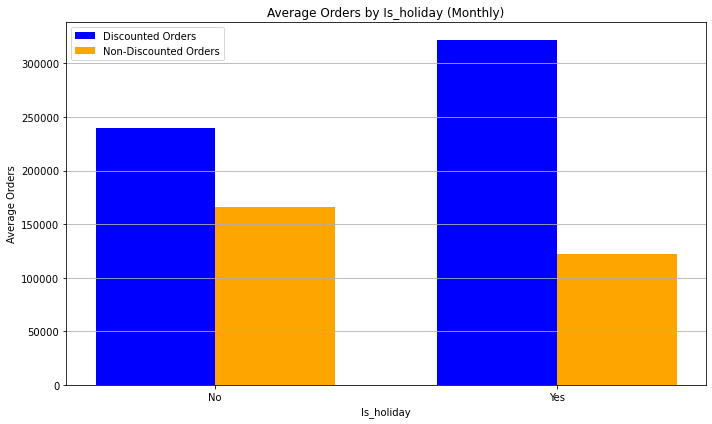

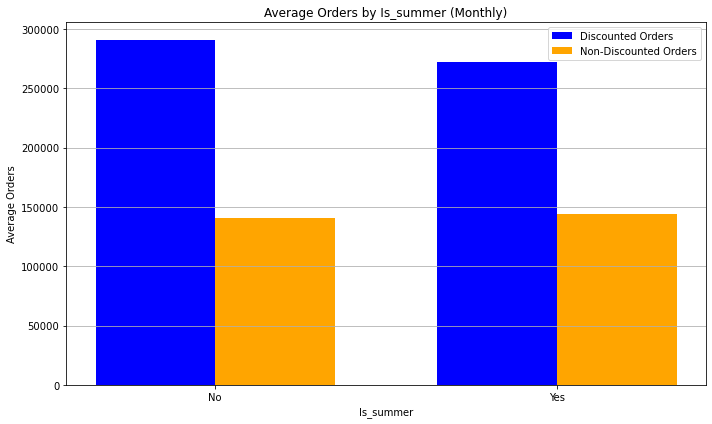

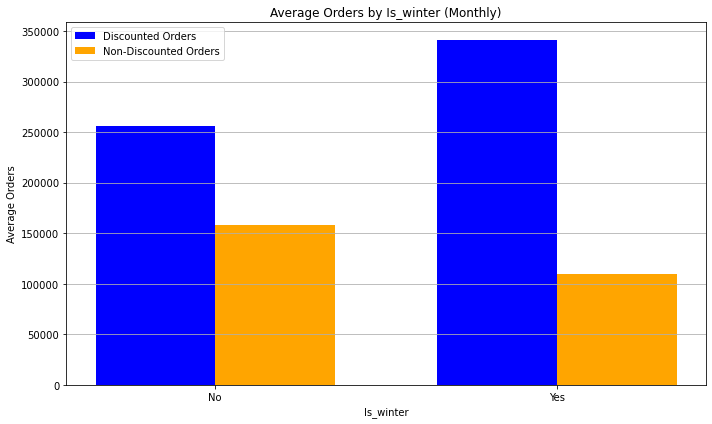

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load cleaned data
file_path = 'cleaned_orders_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate the discount column segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Drop rows with NaN values
monthly_data.dropna(inplace=True)

# Verify the aggregation
print("Discounted Monthly Aggregation:")
print(discounted_monthly.head())
print("\nNon-Discounted Monthly Aggregation:")
print(non_discounted_monthly.head())
print("\nMerged Monthly Data (after NaN removal):")
print(monthly_data.head())

# Step 1: Correlation Analysis
if 'discount' in discounted_monthly.columns and 'orders' in discounted_monthly.columns:
    pearson_corr, _ = pearsonr(monthly_data['discount'], monthly_data['orders_discounted'])
    spearman_corr, _ = spearmanr(monthly_data['discount'], monthly_data['orders_discounted'])
    print(f"Pearson Correlation (Discounted Orders): {pearson_corr:.3f}")
    print(f"Spearman Correlation (Discounted Orders): {spearman_corr:.3f}")

# Step 2: Price Elasticity of Demand
monthly_data['pct_change_discount'] = monthly_data['discount'].pct_change().fillna(0)
monthly_data['pct_change_orders_discounted'] = monthly_data['orders_discounted'].pct_change().fillna(0)

monthly_data['elasticity'] = (
    monthly_data['pct_change_orders_discounted'] / monthly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# Elasticity summary
avg_elasticity = monthly_data['elasticity'].mean()
print(f"\nAverage Price Elasticity of Demand (Discounted Orders): {avg_elasticity:.3f}")

# Step 3: Investigating Extreme Elasticity Months
extreme_elasticity_months = monthly_data.loc[monthly_data['elasticity'].abs() > 5]
print("\nExtreme Elasticity Months for Discounted Orders:")
print(extreme_elasticity_months[['date_of_order', 'elasticity', 'discount', 'orders_discounted']])

# Step 4: Seasonal Analysis of Orders
monthly_data['is_holiday'] = np.random.choice([0, 1], size=len(monthly_data))
monthly_data['is_summer'] = monthly_data['date_of_order'].dt.month.isin([6, 7, 8]).astype(int)
monthly_data['is_winter'] = monthly_data['date_of_order'].dt.month.isin([12, 1, 2]).astype(int)
# Step 4: Seasonal Analysis of Orders (Separated Bar Graphs)
# Seasonal Analysis of Orders (Side-by-side Bar Graphs)
seasonal_features = ['is_holiday', 'is_summer', 'is_winter']

for feature in seasonal_features:
    seasonal_orders = monthly_data.groupby(feature)[['orders_discounted', 'orders_non_discounted']].mean()
    
    # Plotting side-by-side bar graph
    bar_width = 0.35
    index = np.arange(len(seasonal_orders))
    
    plt.figure(figsize=(10, 6))
    plt.bar(index, seasonal_orders['orders_discounted'], bar_width, label='Discounted Orders', color='blue')
    plt.bar(index + bar_width, seasonal_orders['orders_non_discounted'], bar_width, label='Non-Discounted Orders', color='orange')
    
    plt.title(f'Average Orders by {feature.capitalize()} (Monthly)')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Average Orders')
    plt.xticks(index + bar_width / 2, ['No', 'Yes'])  # Assuming binary features (0 and 1)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import platform

# Display system details
print(platform.platform())
print(platform.processor())

# Load dataset
data = pd.read_csv('cleaned_orders_discount_data.csv')

# Updated Departments: Adding more relevant departments
selected_departments = [
    'MENS OWN BRAND FOOTWEAR', 'MENS OWN BRAND OUTERWEAR', 'MENS BRANDED FOOTWEAR',
    'MENS OWN BRAND TOPS', 'MENS BRANDED CLOTHING'
]
data = data[data['department_desc'].isin(selected_departments)]

# Handle duplicate discounts by averaging
data = data.groupby(['product_number', 'date_of_order']).agg({
    'discount': 'mean',
    'orders': 'mean',
    'department_desc': 'first'  # Retain the first department for duplicates
}).reset_index()

# Enhanced Feature Engineering
def preprocess_data(data):
    data['date_of_order'] = pd.to_datetime(data['date_of_order'], errors='coerce')
    data['day_of_week'] = data['date_of_order'].dt.dayofweek  # 0=Monday, 6=Sunday
    data['month'] = data['date_of_order'].dt.month
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  # 1 if Saturday/Sunday
    data['quarter'] = data['date_of_order'].dt.quarter
    data['is_summer'] = data['month'].isin([6, 7, 8]).astype(int)  # June, July, August
    data['is_winter'] = data['month'].isin([12, 1, 2]).astype(int)  # December, January, February
    
    
    data.drop(columns=['date_of_order'], inplace=True, errors='ignore')
    data = pd.get_dummies(data, columns=['department_desc'], drop_first=True)
    return data

data = preprocess_data(data)

# Define Features and Target
def train_model(data, dataset_name):
    X = data.drop(columns=['orders'])
    y = data['orders']

    # Ensure no missing values
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(alpha=0.01),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(),
    }

    results = []
    best_model = None
    best_r2 = float('-inf')
    decision_tree_model = None  # Save Decision Tree model for visualization

    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {dataset_name} dataset...")
        if model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
            param_grids = {
                'Decision Tree': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 10, 20]},
                'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
                'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
            }
            search = RandomizedSearchCV(
                model, param_distributions=param_grids[model_name], n_iter=5, cv=2, random_state=42, n_jobs=-1
            )
            search.fit(X_train, y_train)
            model = search.best_estimator_
            print(f"Best Params for {model_name}: {search.best_params_}")
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        print(f"{model_name} Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

        results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R^2': r2})

        if model_name == 'Decision Tree':
            decision_tree_model = model
        if r2 > best_r2:
            best_r2 = r2
            best_model = model

    # Visualize Decision Tree
    if decision_tree_model:
        plt.figure(figsize=(10, 6))
        plot_tree(decision_tree_model, feature_names=list(X.columns), filled=True, max_depth=3, fontsize=8)
        plt.title(f"Decision Tree Diagram ({dataset_name} Dataset, Depth=3)")
        plt.tight_layout()
        plt.savefig(f"decision_tree_diagram_{dataset_name}.png")
        plt.show()

    # Save metrics to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'model_evaluation_metrics_{dataset_name}.csv', index=False)

    # Save predictions to CSV
    test_data = data.iloc[y_test.index].copy()
    test_data['Predictions'] = np.round(best_model.predict(X_test))
    test_data.to_csv(f'predicted_orders_{dataset_name}.csv', index=False)
    print(f"\nModel evaluation metrics saved for {dataset_name} dataset.")

# Train model on processed data
train_model(data, "Expanded_Departments")
plt.show()


macOS-14.6.1-arm64-arm-64bit
arm

Training Linear Regression on Expanded_Departments dataset...
Linear Regression Results:
MAE: 7.0260, RMSE: 11.6335, R2: 0.0551

Training Lasso Regression on Expanded_Departments dataset...
Lasso Regression Results:
MAE: 7.0263, RMSE: 11.6342, R2: 0.0550

Training Decision Tree on Expanded_Departments dataset...
Best Params for Decision Tree: {'min_samples_split': 10, 'max_depth': None}
Decision Tree Results:
MAE: 4.2036, RMSE: 8.0436, R2: 0.5483

Training Random Forest on Expanded_Departments dataset...
